## 问题定义

问题定义如下图，矩形求解区域，长宽为0.1m，上侧面为从左至右的1m/s的滑移边界，其他三个侧面为无滑移边界。雷诺数为10。
![Problem](./resource/problem_define.png)

对待求解问题的数学描述如下：
![Equation](./resource/equation.png)

其中，$u,v$分别为x方向速度，y方向速度，$p$为压强，$\nu,\rho$分别为运动粘度和密度。在本求解中定义$\nu=0.01$，$\rho=1.0$

### 求解目标

给定坐标$(x,y)$求解稳态结果（$u,v, p$）

## FBPINN

论文：Moseley, Ben, Andrew Markham, and Tarje Nissen-Meyer. "Finite Basis Physics-Informed Neural Networks (FBPINNs): a scalable domain decomposition approach for solving differential equations." Advances in Computational Mathematics 49.4 (2023): 62.

这个模型提出通过将PINN进行极细粒度的重叠分解从而解决全局PINN优化困难的问题


## 求解

In [1]:
import os
import warnings

# optional
# set appropriate GPU in case of multi-GPU machine
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
# 必要的符号运算
from sympy import Symbol, Eq, Abs, tanh, lambdify

import numpy as np

import modulus.sym

# 超参数
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra import to_absolute_path, instantiate_arch, ModulusConfig
from modulus.sym.hydra.utils import compose

# 求解器
from modulus.sym.solver import Solver

# domain
from modulus.sym.domain import Domain

# 几何物体
from modulus.sym.geometry.primitives_2d import Rectangle

# 约束
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)

# validator
from modulus.sym.domain.validator import PointwiseValidator

# inferencer
from modulus.sym.domain.inferencer import PointwiseInferencer
from modulus.sym.key import Key

# Equation
from modulus.sym.eq.pdes.navier_stokes import NavierStokes

# post process
from modulus.sym.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter,
)
import matplotlib.pyplot as plt

from modulus.sym.node import Node

In [3]:
cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/usr/local/lib/python3.10/dist-packages/modulus/sym/hydra/utils.py:148: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:
  fully_connected:
    arch_type: fully_connected
    input_keys: ???
  

### 定义必要组件

#### PDE

In [4]:
ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)

#### Model

In [5]:

# 定义简单的全连接网络
# 输入为坐标x和y
# 输出为两个方向的速度u,v以及压强p

# 两个模型
flow_net_1 = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u_1"), Key("v_1"), Key("p_1")],
    cfg=cfg.arch.fully_connected,
)
flow_net_2 = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u_2"), Key("v_2"), Key("p_2")],
    cfg=cfg.arch.fully_connected,
)

#### FBPINN必要组件

叠加函数

In [6]:
x, y = Symbol("x"), Symbol("y")
basis_function_1 = 0.5 * (tanh(25 * (0 - y)) + tanh(25 * (y + 1)))
basis_function_2 = 0.5 * (tanh(25 * (1 - y)) + tanh(25 * (y + 0)))

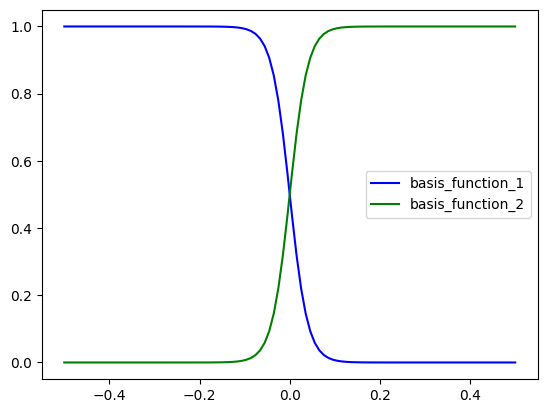

In [7]:
basis_function_1_lf = lambdify(y, basis_function_1, "numpy")
basis_function_2_lf = lambdify(y, basis_function_2, "numpy")
y_vals = np.linspace(-0.5, 0.5, 100)

out_bf_1 = basis_function_1_lf(y_vals)
out_bf_2 = basis_function_2_lf(y_vals)

plt.figure()
plt.plot(y_vals, out_bf_1, label="basis_function_1", color="blue")
plt.plot(y_vals, out_bf_2, label="basis_function_2", color="green")

plt.legend()
plt.show()

#### 组合节点

组合两个子模型的额外自定义节点

In [8]:
# nodes to merge the results of the two networks
custom_nodes = [
    Node.from_sympy(
        Symbol("u_1") * basis_function_1 + Symbol("u_2") * basis_function_2,
        "u",
    )
]
custom_nodes += [
    Node.from_sympy(
        Symbol("v_1") * basis_function_1 + Symbol("v_2") * basis_function_2,
        "v",
    )
]
custom_nodes += [
    Node.from_sympy(
        Symbol("p_1") * basis_function_1 + Symbol("p_2") * basis_function_2,
        "p",
    )
]

In [9]:
nodes = (
    ns.make_nodes()
    + custom_nodes
    + [flow_net_1.make_node(name="flow_network_1")]
    + [flow_net_2.make_node(name="flow_network_2")]
)

#### Geo

In [10]:
# 长宽均为1的矩形
height = 0.1
width = 0.1
x, y = Symbol("x"), Symbol("y")
rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

#### Domain

在Domain中定义约束以及训练所需的各种组件

In [11]:
# make ldc domain
ldc_domain = Domain()

四个边界条件

In [12]:
# 顶部滑移边界
# 水平速度为1.0，垂直速度为0
# 注意lambda_weighting参数，这个参数定义了样本权重，在本示例中，约靠近边界，样本的权重越小
# criteria定义了采样的位置
# outvar定义了边界条件

# 注意总点数
# 这里的batch_size定义了每一个batch的采样数，
# 此外还有一个参数是batch_per_epoch (default: 1000)
# 实际的总采样数为batch_per_epoch * batch_size
top_wall = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": 1.0, "v": 0},
    batch_size=cfg.batch_size.TopWall,
    lambda_weighting={"u": 1.0 - 20 * Abs(x), "v": 1.0},  # weight edges to be zero
    criteria=Eq(y, height / 2),
)
ldc_domain.add_constraint(top_wall, "top_wall")

# 左右以及下侧的无滑移边界
no_slip = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": 0, "v": 0},
    batch_size=cfg.batch_size.NoSlip,
    criteria=y < height / 2,
)
ldc_domain.add_constraint(no_slip, "no_slip")

内部满足PDE约束

In [13]:
# interior
# 由于本求解中NS方程直接调用的模型，所以这里outvar直接使用了对应的key
# 具体定义可参考modulus/eq/pdes/navier_stokes.py
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"continuity": 0, "momentum_x": 0, "momentum_y": 0},
    batch_size=cfg.batch_size.Interior,
    lambda_weighting={
        "continuity": Symbol("sdf"),
        "momentum_x": Symbol("sdf"),
        "momentum_y": Symbol("sdf"),
    },
)
ldc_domain.add_constraint(interior, "interior")

验证器以及其他必要组件

In [14]:
# 数据目录
file_path = "openfoam/cavity_uniformVel0.csv"
if os.path.exists(to_absolute_path(file_path)):
    mapping = {"Points:0": "x", "Points:1": "y", "U:0": "u", "U:1": "v", "p": "p"}
    openfoam_var = csv_to_dict(to_absolute_path(file_path), mapping)
    openfoam_var["x"] += -width / 2  # center OpenFoam data
    openfoam_var["y"] += -height / 2  # center OpenFoam data
    
    # 输入数据
    openfoam_invar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["x", "y"]
    }
    # 输出数据
    openfoam_outvar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["u", "v"]
    }
    
    # 创建validator
    openfoam_validator = PointwiseValidator(
        nodes=nodes,
        invar=openfoam_invar_numpy,
        true_outvar=openfoam_outvar_numpy,
        batch_size=1024,
        plotter=ValidatorPlotter(),
    )
    ldc_domain.add_validator(openfoam_validator)

    # 创建inferencer
    grid_inference = PointwiseInferencer(
        nodes=nodes,
        invar=openfoam_invar_numpy,
        output_names=["u", "v", "p"],
        batch_size=1024,
        plotter=InferencerPlotter(),
    )
    ldc_domain.add_inferencer(grid_inference, "inf_data")
else:
    warnings.warn(
        f"Directory {file_path} does not exist. Will skip adding validators. Please download the additional files from NGC https://catalog.ngc.nvidia.com/orgs/nvidia/teams/modulus/resources/modulus_sym_examples_supplemental_materials"
    )

### 求解器以及求解

In [15]:
# 定义求解器
slv = Solver(cfg, ldc_domain)

手动加载日志系统

In [16]:
import logging
# logging.getLogger().addHandler(logging.StreamHandler())
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

启动求解

In [17]:
slv.solve()

2024-02-27 09:45:01,427 - WARNING - Installed PyTorch version 2.2.0a0+81ea7a4 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
2024-02-27 09:45:01,436 - INFO - attempting to restore from: /workspace/11_2D_LDC_FBPINN/outputs
2024-02-27 09:45:01,437 - WARNING - optimizer checkpoint not found
2024-02-27 09:45:01,437 - WARNING - model flow_network_1.0.pth not found
2024-02-27 09:45:01,437 - WARNING - model flow_network_2.0.pth not found
2024-02-27 09:45:02,920 - INFO - [step:          0] record constraint batch time:  2.329e-01s
2024-02-27 09:45:10,262 - INFO - [step:          0] record validators time:  7.340e+00s
2024-02-27 09:45:15,326 - INFO - [step:          0] record inferencers time:  5.037e+00s
2024-02-27 09:45:15,392 - INFO - [step:          0] saved checkpoint to /workspace/11_2D_LDC_FBPINN/outputs
2024-02-27 09:45:15,393 - INFO - [step:          0] loss:  5.039e-02
2024-02-27 09:45:18,402 - INFO - Attempting cuda graph building, this may 

2024-02-27 09:52:59,183 - INFO - [step:       6000] record constraint batch time:  9.974e-02s
2024-02-27 09:53:06,062 - INFO - [step:       6000] record validators time:  6.877e+00s
2024-02-27 09:53:10,859 - INFO - [step:       6000] record inferencers time:  4.779e+00s
2024-02-27 09:53:10,925 - INFO - [step:       6000] saved checkpoint to /workspace/11_2D_LDC_FBPINN/outputs
2024-02-27 09:53:10,927 - INFO - [step:       6000] loss:  2.593e-04, time/iteration:  1.928e+02 ms
2024-02-27 09:53:17,577 - INFO - [step:       6100] loss:  2.268e-04, time/iteration:  6.649e+01 ms
2024-02-27 09:53:24,229 - INFO - [step:       6200] loss:  2.582e-04, time/iteration:  6.650e+01 ms
2024-02-27 09:53:30,882 - INFO - [step:       6300] loss:  2.276e-04, time/iteration:  6.651e+01 ms
2024-02-27 09:53:37,533 - INFO - [step:       6400] loss:  3.415e-04, time/iteration:  6.649e+01 ms
2024-02-27 09:53:44,190 - INFO - [step:       6500] loss:  1.685e-04, time/iteration:  6.655e+01 ms
2024-02-27 09:53:50,8

### 后处理以及可视化

对于jupyter，比较方便的方法是使用matplotlib

此外，还可以使用tensorboard以及Paraview

如果使用了PointwiseValidator则可以直接查看验证的结果：

![u](./outputs/validators/validator_u.png)
![v](./outputs/validators/validator_v.png)